In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd().parent))
sys.path.append(str(Path.cwd().parent / 'label_anything'))
sys.path.append(str(Path.cwd().parent / 'label_anything' / 'data'))

In [77]:
from data.dataset import LabelAnythingDataset, VariableBatchSampler
from transforms import CustomResize, CustomNormalize

from label_anything import LabelAnything
from label_anything.data import get_preprocessing
from label_anything.models import model_registry
from label_anything.experiment.substitution import Substitutor
from label_anything.utils.utils import ResultDict
from label_anything.data.utils import BatchKeys
import json
import matplotlib.pyplot as plt
import numpy as np
import yaml
from pathlib import Path
import torch
from torchvision.transforms import Compose, ToTensor, Resize, PILToTensor
from torchvision.transforms.functional import resize
from torch.utils.data import DataLoader
import timeit
from PIL import Image
import numpy as np
import cv2
import lovely_tensors as lt
from einops import rearrange, repeat
from sklearn.decomposition import PCA
import torch.nn as nn
lt.monkey_patch()

In [3]:
%matplotlib inline

In [4]:
# Functions for visualization

def get_image(image_tensor):
    MEAN = np.array([123.675, 116.280, 103.530]) / 255
    STD = np.array([58.395, 57.120, 57.375]) / 255
    unnormalized_image = (image_tensor.numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    return Image.fromarray(unnormalized_image)

def draw_masks(img: Image, masks: torch.Tensor, colors):
    # here masks is a dict having category names as keys
    # associated to a list of binary masks
    masked_image = resize(img.copy(), 256)
    
    for i, mask in enumerate(masks):
        mask = mask.numpy()
        masked_image = np.where(np.repeat(mask[:, :, np.newaxis], 3, axis=2),
                                np.asarray(colors[i], dtype="uint8"),
                                masked_image)
    
    masked_image = masked_image.astype(np.uint8)
    return cv2.addWeighted(np.array(resize(img, 256)), 0.3, masked_image, 0.7, 0)

def draw_boxes(img: Image, boxes: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(boxes):
        for box in cat:
            x1, y1, x2, y2 = box
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            img = cv2.rectangle(img, (x1, y1), (x2, y2), colors[i], 2)
    return img

def draw_points(img: Image, points: torch.Tensor, colors):
    img = np.array(img)
    
    for i, cat in enumerate(points):
        for point in cat:
            x, y = point
            x, y = int(x), int(y)
            img = cv2.circle(img, (x, y), 5, colors[i], -1)
    return img

def draw_all(img: Image, masks, boxes, points, colors):
    segmented_image = draw_masks(img, masks, colors)
    img = Image.fromarray(segmented_image)
    img = resize(img, 480)
    img = draw_boxes(img, boxes, colors)
    img = Image.fromarray(img)
    img = draw_points(img, points, colors)
    img = Image.fromarray(img)
    return img

def resize_ground_truth(ground_truth, dims):
    return ground_truth[:dims[0], :dims[1]]

def feature_map_pca_heatmap(feature_map):
    """
    Given a feature map of shape (D, H, W), performs PCA along the feature dimension
    and returns a heatmap based on the first principal component.
    
    Args:
        feature_map (torch.Tensor): Input tensor of shape (D, H, W).
    
    Returns:
        heatmap (torch.Tensor): Heatmap of shape (H, W) based on the first principal component.
    """
    # Check the input dimensions
    D, H, W = feature_map.shape
    feature_map_reshaped = feature_map.view(D, -1).T  # Reshape to (H*W, D)

    # Convert to numpy for PCA
    feature_map_np = feature_map_reshaped.cpu().numpy()
    
    # Perform PCA
    pca = PCA(n_components=1)
    principal_component = pca.fit_transform(feature_map_np)
    
    # Reshape the result back to (H, W) and convert it to a tensor
    heatmap = torch.tensor(principal_component).view(H, W)
    
    # Normalize the heatmap for better visualization
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())
    
    return heatmap

def feature_vector_2D_pca(feature_vector):
    """
    Given a feature vector of shape (N, D), performs PCA along the feature dimension
    and returns the first two principal components.
    
    Args:
        feature_vector (torch.Tensor): Input tensor of shape (N, D).
    
    Returns:
        principal_components (torch.Tensor): Principal components of shape (N, 2).
    """
    if len(feature_vector.shape) == 3:
        if feature_vector.shape[0] == 1:
            feature_vector = feature_vector[0]
        else:
            raise ValueError("The input tensor must have a shape of (N, D) where N > 1.")
    elif len(feature_vector.shape) != 2:
        raise ValueError("The input tensor must have a shape of (N, D) where N > 1.")
    # Check the input dimensions
    N, D = feature_vector.shape

    # Convert to numpy for PCA
    feature_vector_np = feature_vector.cpu().numpy()
    
    # Perform PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(feature_vector_np)
    
    # Convert the result back to a tensor
    principal_components = torch.tensor(principal_components)
    
    return principal_components

colors = [
    # yellow
    (255, 255, 0),
    # red
    (255, 0, 0),
    # green
    (0, 255, 0),
    # blue
    (0, 0, 255),
    # purple
    (255, 0, 255),
    # cyan
    (0, 255, 255),
    # orange
    (255, 165, 0),
    # pink
    (255, 192, 203),
    # brown
    (139, 69, 19),
    # grey
    (128, 128, 128),
    # black
    (0, 0, 0)
]*3

In [5]:
RAW_DATA_DIR = Path.cwd().parent / "data"

In [58]:
dataset_params = {
    "datasets": {
        "val_pascal5i_N2K1": {
            "name": "pascal",
            "data_dir": RAW_DATA_DIR / "pascal",
            # "emb_dir": RAW_DATA_DIR / "pascal/embeddings_vit_mae_480",
            "split": "val",
            "val_fold_idx": 0,
            "n_folds": 4,
            "n_shots": 1,
            "n_ways": 2,
            "do_subsample": False
        }
    },
    "common": {
        "remove_small_annotations": True,
        "image_size": 480,
        "custom_preprocess": False
    }
}

In [59]:
preprocess = get_preprocessing(dataset_params)

In [60]:
val_datsets = {}
common_params = dataset_params["common"]
for name, single_dataset_params in dataset_params["datasets"].items():
    splits = name.split("_")
    if len(splits) > 2:
        dataset_name = "_".join(splits[:2])
    dataset = LabelAnythingDataset(
        datasets_params={dataset_name: single_dataset_params},
        common_params={**common_params, "preprocess": preprocess},
    )
    val_datsets[name] = dataset

Loading image filenames from val...
[2024-11-25 11:03:02] WARNING - pascal.py - load_embeddings is not specified. Assuming load_embeddings=False.


Loading annotations...: 100%|██████████| 1449/1449 [00:01<00:00, 833.40it/s]


In [61]:
sampler = VariableBatchSampler(
        dataset,
        possible_batch_example_nums=[[1, 2, 1]],
        num_processes=1,
        shuffle=False,
)

In [62]:
val_datsets.keys()

dict_keys(['val_pascal5i_N2K1'])

In [63]:
chosen_dataset = "val_pascal5i_N2K1"

dataset = val_datsets["val_pascal5i_N2K1"]

In [64]:
dataloader = DataLoader(
        dataset=dataset, batch_sampler=sampler, collate_fn=dataset.collate_fn
)

In [125]:
params = \
    """  
    name: [lam_no_vit] # path to model class or model name contained in EzDL or super-gradients
    spatial_convs: [3]
    class_attention: [False]
    example_attention: [False]
    example_class_attention: [False]
    fusion_transformer: [TwoWayTransformer]
    image_embed_dim: [768]
    embed_dim: &embed_dim [256]
    image_size: &image_size [480]
    embeddings_per_example: [4]
    use_prompt_chooser: [True]
    checkpoint: ["../checkpoints/pascal/fold0_maechooser_cr43qkjc.safetensors"]
    """
params = yaml.safe_load(params)
params = {k: v[0] for k, v in params.items()}

name = params.pop("name")

la = model_registry[name](**params)

Error loading state_dict, trying to load without 'model.' prefix
State_dict loaded successfully


In [126]:
la.image_encoder = model_registry["vit_b_mae"]()

You are using a model of type vit_mae to instantiate a model of type vit. This is not supported for all configurations of models and can yield errors.
Some weights of ViTModelWrapper were not initialized from the model checkpoint at facebook/vit-mae-base and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [127]:
# la = LabelAnything.from_pretrained("pasqualedem/label_anything_coco_fold0_mae_7a5p0t63").model.eval()

In [178]:
idx = 3
for batch_idx, ((batch, gt), _) in enumerate(dataloader):
    print(batch_idx)
    if batch_idx == idx:
        break 

0
1
2
3


In [179]:
sample = {
    k: v[0] for k, v in batch.items()
}

In [180]:
images = [
    draw_all(
        get_image(sample["images"][i]),
        sample["prompt_masks"][i],
        sample["prompt_bboxes"][i],
        sample["prompt_points"][i],
        colors
    )
    for i in range(sample["images"].shape[0])
]

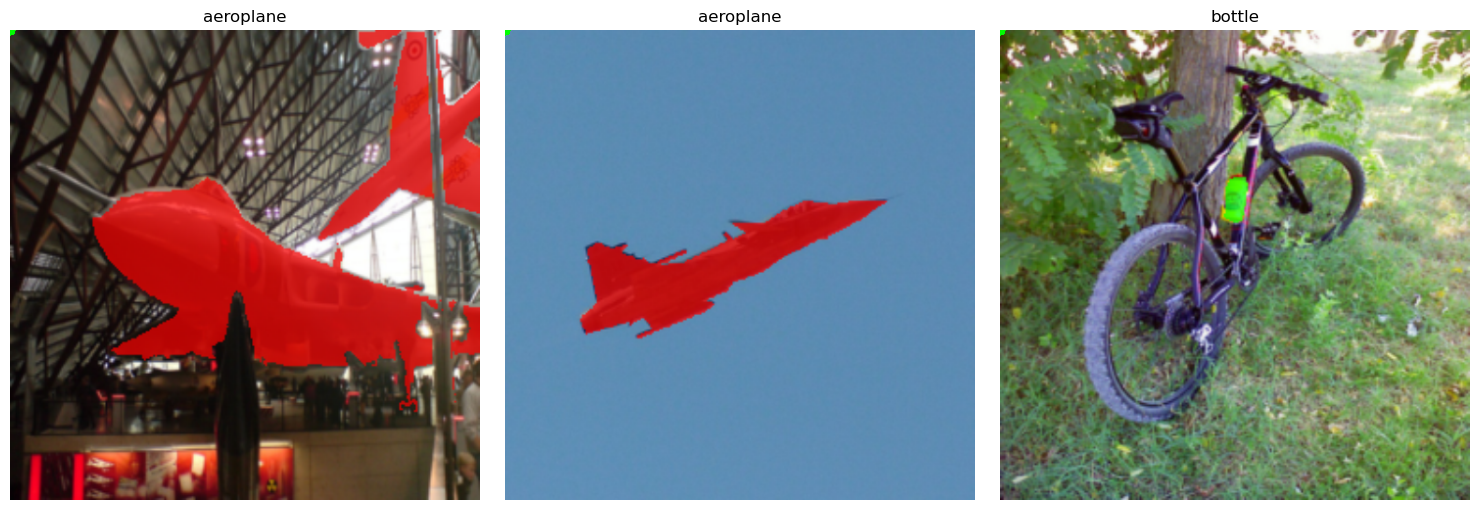

In [181]:
# show examples in a single figure
fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
for i, (example, ax) in enumerate(zip(images, axes)):
    cats = [dataset.categories["val_pascal5i"][cat]["name"] for cat in sample["classes"][i]]
    ax.set_title(", ".join(cats))
    ax.imshow(example)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [182]:
sub = Substitutor(substitute=False)
sub.reset((batch, gt))
batch_dict, gt = next(sub)

In [183]:
with torch.no_grad():
    query_embeddings, prompt_embeddings = la.prepare_query_example_embeddings(batch_dict)

In [184]:
q_pca = feature_map_pca_heatmap(query_embeddings[0])
s_pca = torch.stack([feature_map_pca_heatmap(prompt_embedding) for prompt_embedding in prompt_embeddings[0]])
qs_pca = torch.cat([q_pca.unsqueeze(0), s_pca], dim=0)

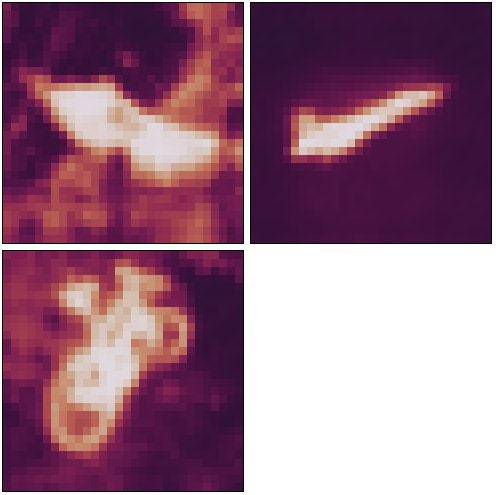

In [185]:

qs_pca.chans(scale=8)

In [189]:
with torch.no_grad():
    points, boxes, masks, flag_examples = la.prepare_prompts(batch_dict)
    sparse_embeddings, dense_embeddings = la.prompt_encoder.embed_points_masks(
        points, boxes, masks, chunk_size=None
    )
    sparse_embeddings = rearrange(sparse_embeddings, "b m c n d -> (b m c) n d")

    b, m, c, d, h, w = dense_embeddings.shape
    dense_embeddings = rearrange(dense_embeddings, "b m c d h w -> (b m c) d h w")

    if prompt_embeddings.shape[-2:] != dense_embeddings.shape[-2:]:
        dense_embeddings = nn.functional.interpolate(
            dense_embeddings,
            size=prompt_embeddings.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

    if la.prompt_encoder.use_support_features:
        src = rearrange(prompt_embeddings, "b m d h w -> b m 1 d h w").repeat(
            1, 1, c, 1, 1, 1
        )
        src = rearrange(src, "b m c d h w -> (b m c) d h w")
        src = src + dense_embeddings
    else:
        src = dense_embeddings
    pos_src = torch.repeat_interleave(
        la.prompt_encoder.get_dense_pe(), sparse_embeddings.shape[0], dim=0
    )

In [190]:
# Run the transformer to fuse the dense embeddings and sparse embeddings
with torch.no_grad():
    src = rearrange(src, "(b m c) d h w -> b m c d h w", b=b, m=m, c=c)
    sparse_embeddings = rearrange(
        sparse_embeddings, "(b m c) n d -> b m c n d", b=b, m=m, c=c
    )
    src = la.prompt_encoder.sparse_dense_fusion(
        src, pos_src, sparse_embeddings, chunk_size=None
    )

In [ ]:
fg_flag_examples = flag_examples.clone()
b, m, c  = fg_flag_examples.shape

# Remove bg
fg_flag_examples = fg_flag_examples[:, :, 1:]

src = rearrange(src, "(b m c) d ... -> b m c d ...", b=b, m=m)
fg_src = src[:, :, 1:]
bg_src = fg_src.mean(dim=2).unsqueeze(2)
bg_flag_examples = fg_flag_examples.sum(dim=2).bool().int().unsqueeze(2)
fg_src = rearrange(fg_src, "b m c d ... -> (b m c) d ...", b=b, m=m)
bg_src = rearrange(bg_src, "b m c d ... -> (b m c) d ...", b=b, m=m, c=1)

fg_mask = torch.stack([fg_chooser(fg_src) for fg_chooser in la.prompt_encoder.prompt_chooser.fg_choosers])
bg_mask = torch.stack([bg_chooser(bg_src) for bg_chooser in la.prompt_encoder.prompt_chooser.bg_choosers])

fg_mask = torch.nn.functional.sigmoid(fg_mask)
bg_mask = torch.nn.functional.sigmoid(bg_mask)
        
src = repeat(src, "... -> n ...", n=la.prompt_encoder.prompt_chooser.num_embeddings)

fg = fg_mask * fg_src
bg = bg_mask * bg_src

fg = nn.functional.adaptive_avg_pool2d(fg, (1, 1))
bg = nn.functional.adaptive_avg_pool2d(bg, (1, 1))
flag_examples = torch.cat([bg_flag_examples, fg_flag_examples], dim=2)
flag_examples = repeat(flag_examples, "b m c -> b (n m) c", n=la.prompt_encoder.prompt_chooser.num_embeddings)

fg = rearrange(fg, "n (b m c) d 1 1 -> b (n m) c d", b=b, m=m, c=(c - 1))
bg = rearrange(bg, "n (b m c) d 1 1 -> b (n m) c d", b=b, m=m, c=1)

embeddings = torch.cat([bg, fg], dim=2)

pe_result = {
    ResultDict.CLASS_EMBS: None,
    ResultDict.EXAMPLES_CLASS_SRC: src,
    ResultDict.EXAMPLES_CLASS_EMBS: embeddings,
    BatchKeys.FLAG_EXAMPLES: flag_examples,
}

In [154]:
image_pe = la.get_dense_pe()

In [155]:
b, d, h, w = query_embeddings.shape
class_embeddings, flag_examples = la.mask_decoder._get_pe_result(
    pe_result, flag_examples
)

embedding_mask = rearrange(flag_examples, "b m c -> b (m c)")
class_embeddings, query_embeddings = la.mask_decoder.transformer(
    query_embeddings, image_pe, class_embeddings, embedding_mask
)
query_embeddings = rearrange(query_embeddings, "b (h w) c -> b c h w", h=h)

upscaled_embeddings, class_embeddings = la.mask_decoder._upscale(
    query_embeddings, class_embeddings
)
upscaled_embeddings = la.mask_decoder._spatial_convs(upscaled_embeddings)

In [156]:
seg = la.mask_decoder._classify(upscaled_embeddings, class_embeddings, flag_examples)

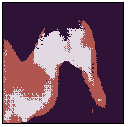

In [157]:
seg = seg.argmax(1)
seg = seg / seg.max()
seg.chans

In [166]:
pe_result["flag_examples"].p

tensor([[[0, 1, 1],
         [1, 0, 1],
         [0, 1, 1],
         [1, 0, 1],
         [0, 1, 1],
         [1, 0, 1],
         [0, 1, 1],
         [1, 0, 1]]], dtype=torch.int32)

In [164]:
fg_mask

tensor[4, 4, 1, 30, 30] n=14400 (56Kb) x∈[1.967e-08, 1.000] μ=0.875 σ=0.331 grad SigmoidBackward0